# Soft SVM Implementation for Determining Credit Card Fraud.

Dataset: [Kaggle-Credit Card Fraud Dataset](https://paperswithcode.com/dataset/kaggle-credit-card-fraud-dataset)

_Data has already undergone PCA and preprocessing to anonymize the data._

The original classes for the data are:

* Fraudulent Transaction: _+1_

* Non-fraudulent Transaction: _0_

In [1]:
%load_ext jupyter_black

In [2]:
import time

import pandas as pd
import numpy as np

Load and modify the class values for SVM.

The modified classes for the data are:

* Fraudulent Transaction: _+1_

* Non-fraudulent Transaction: _-1_

In [3]:
data: pd.DataFrame = pd.read_csv("../creditcard.csv")
data["Class"] = np.where(data["Class"] <= 0, -1, 1)

data.shape

(284807, 31)

Preview the data

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,-1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,-1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,-1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,-1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,-1


## Split the Data for Training and Testing

In [5]:
# Split data into training/testing
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    data, test_size=0.1, stratify=data["Class"], random_state=42
)

print(
    "NUMBER OF FRAUD SAMPLES IN TOTAL DATASET:    ",
    len(data[data["Class"] == 1]),
    "out of",
    len(data),
)
print(
    "NUMBER OF FRAUD SAMPLES IN TRAINING DATASET: ",
    len(train[train["Class"] == 1]),
    "out of",
    len(train),
)
print(
    "NUMBER OF FRAUD SAMPLES IN TESTING DATASET:  ",
    len(test[test["Class"] == 1]),
    "out of",
    len(test),
)

NUMBER OF FRAUD SAMPLES IN TOTAL DATASET:     492 out of 284807
NUMBER OF FRAUD SAMPLES IN TRAINING DATASET:  443 out of 256326
NUMBER OF FRAUD SAMPLES IN TESTING DATASET:   49 out of 28481


## Implement Soft-SVM

### Soft-SVM Objective

$$\min_{w,b} \frac{1}{2} ||w||^2 + C \sum_i \xi_i$$

$\text{s.t. } y_i(w^T x_i + b) \geq 1 - \xi_i$

$\xi_i \geq 0$

$\text{for } i \in \{1, 2, ..., N\}$

### Slack variable $\xi$

The misclassified points

$$\xi_i = \max(1 - y_i(w^T x_i + b), 0)$$

* If $\xi_i = 0$, correctly classified point outside of the margin.

* If $0 < \xi_i < 1$, correctly classified point within the margin.

* If $\xi_i \geq 1$, misclassified point.

### Hinge-Loss Function

- Counting the distance of the misclassified points from the margin.

$$\min_{w,b} \frac{1}{2} ||w||^2 + C \sum_i \xi_i$$

In [6]:
def hinge_loss(
    X: np.ndarray, Y: np.ndarray, weights: np.ndarray, bias: float, C: float
) -> float:
    """Computes the loss for the current weights and bias.

    Args:
        X (np.ndarray): The features.
        Y (np.ndarray): The labels (either -1 or 1).
        weights (np.ndarray): The current weights of the model.
        bias (float): The current bias of the model.
        C (float): Soft-SVM hyperparameter for adjusting margin size.

    Returns:
        float: The regularized hinge-loss value for the current model.
    """
    # Calculate the slack variable
    hinge = np.maximum(1 - Y * (np.dot(X, weights) + bias), 0)

    # Return the hinge-loss
    return 0.5 * np.linalg.norm(weights) ** 2 + C * np.sum(hinge)

### Fitting the Weights and Bias

1. Initialize weights and bias to 0

2. Determine the margin, or the distance that each sample is from the margin.
    - $m_i = 1- y_i (w^T x_i + b)$

3. Determine the weight gradient:
    - $\nabla_w = w - \frac{C}{n} \sum_{i, \text{where } m_i > 0}^n y_i x_i$
    - Only use points that are either in the margin or misclassified.

4. Determine the bias gradient:
    - $\nabla_b = - \frac{C}{n} \sum_{i, \text{where } m_i > 0}^n y_i$
    - Only use points that are either in the margin or misclassified.

5. Update the weights and bias:
    - $w \leftarrow w - \eta \nabla_w$
    - $b \leftarrow b - \eta \nabla_b$

- Repeat 2-5 per epoch.



In [7]:
def fit(
    X: np.ndarray,
    Y: np.ndarray,
    learning_rate: float,
    C: float,
    epochs: int,
    class_weights: dict[int, float],
    decay: float,
    log: bool = True,
) -> tuple[np.ndarray, float]:
    """Fits weights and bias for the input data and labels.

    A linear SVM model.

    Weights and bias are initialized to zero.

    The program does the following for each epoch:
    - Computes the margin given the current weights and biases for all samples.
    - Updates the weights using misclassified points which are determined using the margin.
    - Updates the bias using the misclassified points which are determined using the margin.
    - Display the current hinge loss every 50 epochs.

    Args:
        X (np.ndarray): The features.
        Y (np.ndarray): The labels.
        learning_rate (float): The learning rate.
        C (float): Soft-SVM hyperparameter for adjusting margin size.
        epochs (int): The number of epochs the model will run.
        class_weights (dict[int, float]): Extra weight provided to each class. Keys should be -1 and 1.
        decay (float): The rate that the learning rate decays.

    Returns:
        tuple[np.ndarray, float]: The final weights and bias.
    """
    assert set(class_weights.keys()) == {-1, 1}

    num_samples, num_features = X.shape

    # Initialize weights as small, random values.
    weights: np.ndarray = np.random.randn(num_features) * 0.025

    # Initialize weights as zeros.
    # weights: np.ndarray = np.zeros(num_features)

    # Initialize bias as the log-ratio of class weights.
    bias: float = np.log(class_weights[1] / class_weights[-1])

    # Initialize bias as zero.
    # bias: float = 0.0

    time_0 = time.time()

    base_learning_rate: float = learning_rate
    losses: list[float] = list()
    try:
        for epoch in range(epochs):
            # Determine SVM Margins
            margins: np.ndarray = 1 - Y * (np.dot(X, weights) + bias)

            C_weights: np.ndarray = np.where(
                Y == 1, C * class_weights[1], C * class_weights[-1]
            )

            # Determine Gradients - updated using points that are in the margin or misclassified.
            grad_weights = (
                weights
                - np.dot((C_weights * (margins > 0) * Y), X) / num_samples
            )
            grad_bias = np.sum(-C_weights * (margins > 0) * Y) / num_samples

            # Clip Gradients
            grad_weights = np.clip(grad_weights, -1.0, 1.0)
            grad_bias = np.clip(grad_bias, -1.0, 1.0)

            # Update Weights and Biases
            weights -= learning_rate * grad_weights
            bias -= learning_rate * grad_bias

            # Decay Learning Rate
            # learning_rate = base_learning_rate / (1.0 + decay * epoch)

            # Print the loss at every 50th epoch
            if log and (epoch % 50 == 0 or epoch == epochs - 1):
                # Timer Stuff
                time_1 = time.time()
                time_diff = time_1 - time_0
                time_0 = time_1

                losses.append(hinge_loss(X, Y, weights, bias, C))
                loss_diff: float = (
                    losses[-1] - losses[-2] if len(losses) >= 2 else 0.0
                )
                if log:
                    print(
                        f"Epoch {epoch:<5} Loss = {losses[-1]:<10.2e}"
                        + ("\033[92m" if loss_diff < 0 else "\033[91m")
                        + f"\t(Difference: {loss_diff:<+10.2e})"
                        + "\033[0m"
                        + f"\tTime: {time_diff:.2f}, (per epoch: {(time_diff/50):.2f})"
                    )

        return weights, bias, losses
    except (
        KeyboardInterrupt
    ):  # Return on notebook stop, to end training early.
        return weights, bias, losses

### Make Predictions

- Determine the sign of the result of $x$ in $w^T x + b$

- If the sign is _positive_, the prediction is the transaction is **fraudulent**

- If the sign is _negative_, the prediction is the transaction is **not fraudulent**

In [8]:
def predict(X: np.ndarray, weights: np.ndarray, bias: float) -> np.ndarray:
    """Use input weights/bias to predict the label for the input data.

    Args:
        X (np.ndarray): Data used for predictions.
        weights (np.ndarray): Weights used to make predictions.
        bias (float): Bias used to make predictions.

    Returns:
        np.ndarray: The predicted labels for the input data.
    """

    return np.sign(np.dot(X, weights) + bias).astype(int)

### Model Evaluation Metrics

In [9]:
import sklearn.metrics


def evaluate(
    prediction_column_name: str,
) -> tuple[tuple[float, float, float, float], tuple[float, float, float]]:
    TP = ((test[prediction_column_name] == 1) & (test["Class"] == 1)).sum()
    TN = ((test[prediction_column_name] == -1) & (test["Class"] == -1)).sum()
    FP = ((test[prediction_column_name] == 1) & (test["Class"] == -1)).sum()
    FN = ((test[prediction_column_name] == -1) & (test["Class"] == 1)).sum()

    precision: float = np.nan
    if (TP + FP) > 0:
        precision = TP / (TP + FP)

    recall: float = np.nan
    if (TP + FN) > 0:
        recall = TP / (TP + FN)

    f1: float = np.nan
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)

    print(f"Actual Fraud (Class=1):      {(test['Class'] == 1).sum()}")
    print(f"Actual Non-Fraud (Class=-1): {(test['Class'] == -1).sum()}")
    print()
    print(f"TP: {TP}")
    print(f"TN: {TN}")
    print(f"FP: {FP}")
    print(f"FN: {FN}")
    print()
    print(f"PRECISION: {precision}")
    print(f"RECALL:    {recall}")
    print(f"F1-SCORE:  {f1}")
    print()

    auprc = sklearn.metrics.average_precision_score(
        test["Class"], test[prediction_column_name]
    )
    print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc}")

    return (TP, TN, FP, FN), (precision, recall, f1)

## Train the Model

### Training Data

In [10]:
X_train = train.drop("Class", axis=1).to_numpy()
Y_train = train["Class"].to_numpy()

### Kernel Trick

Gaussian (RBF):

$$K(x_i, x_j) = \exp(-\frac{1}{2 \sigma^2} ||x_i - x_j||^2) = \exp(-\gamma ||x_i - x_j||^2)$$

In [11]:
use_kernel: bool = True

if use_kernel:
    from sklearn.kernel_approximation import RBFSampler

    gamma: float = 0.08
    n_components: int = 300

    rbf_kernel = RBFSampler(
        gamma=gamma, n_components=n_components, random_state=42
    )

    X_train_kernel = rbf_kernel.fit_transform(X_train)  # Apply the Kernel

### Parameters

In [12]:
# For Fitting
C: float = 50.0
epochs: int = 2500
learning_rate: float = 0.125
class_weights: dict[int, float] = {-1: 1.0, 1: 100.0}
decay = 1e-4

### Fit the Model

In [13]:
# Fit the Model based on the previously specified parameters.
w, b, losses = fit(
    X_train if not use_kernel else X_train_kernel,
    Y_train,
    learning_rate=learning_rate,
    C=C,
    epochs=epochs,
    class_weights=class_weights,
    decay=decay,
)

print()
print(f"WEIGHTS: {w}")
print(f"BIAS:    {b}")

Epoch 0     Loss = 7.01e+07  	(Difference: +0.00e+00 )	Time: 0.12, (per epoch: 0.00)
Epoch 50    Loss = 5.27e+04  	(Difference: -7.01e+07 )	Time: 6.16, (per epoch: 0.12)
Epoch 100   Loss = 5.10e+04  	(Difference: -1.69e+03 )	Time: 6.10, (per epoch: 0.12)
Epoch 150   Loss = 5.10e+04  	(Difference: -5.76e+00 )	Time: 6.08, (per epoch: 0.12)
Epoch 200   Loss = 5.10e+04  	(Difference: +4.55e+00 )	Time: 6.31, (per epoch: 0.13)

WEIGHTS: [ 5.22579922e-03 -3.28285953e-03 -5.20601796e-03  2.05886710e-02
  5.73828824e-04 -1.34473285e-02 -1.34965766e-02  3.25781882e-03
 -1.31553184e-02 -1.27392125e-02 -5.72684290e-04  1.27167470e-02
 -4.92622916e-03 -2.85270813e-02 -9.04439368e-03  3.11653973e-03
  2.97557069e-03  1.36283534e-02  2.31976637e-02 -2.28636349e-02
 -1.80156441e-03  2.22552326e-03 -7.66954013e-03 -1.88525064e-02
  2.12865433e-02  1.16528088e-02 -2.55745238e-02 -1.34157142e-03
 -1.70415934e-02  1.14519349e-02  1.59961508e-02  8.38790125e-05
 -8.27760375e-03 -1.35311164e-02 -1.42388563e

## Test the Model

### Plot Loss over Time

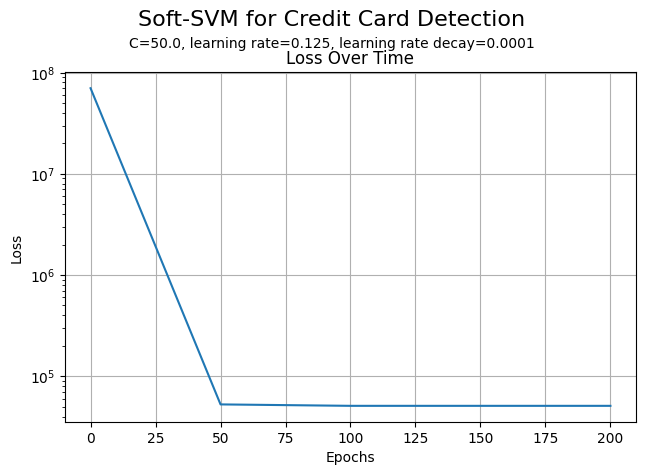

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(np.arange(len(losses)) * 50, losses)

fig.suptitle("Soft-SVM for Credit Card Detection", fontsize=16)
fig.text(
    0.5,
    0.9,
    f"C={C}, learning rate={learning_rate}, learning rate decay={decay}",
    horizontalalignment="center",
)
ax.set_title("Loss Over Time")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.grid(True)
fig.tight_layout()

ax.set_yscale("log")

### Get Predictions on Test Dataset

In [15]:
feature_columns = [
    col for col in test.columns if col not in ["Class", "PredictedClass"]
][:30]
X_test = test[feature_columns].to_numpy()
Y_test = test["Class"].to_numpy()

if use_kernel:
    X_test_kernel = rbf_kernel.transform(X_test)

test["PredictedClass"] = predict(
    X_test if not use_kernel else X_test_kernel, w, b
)

### Visualize Score Distribution

Text(0, 0.5, 'Count')

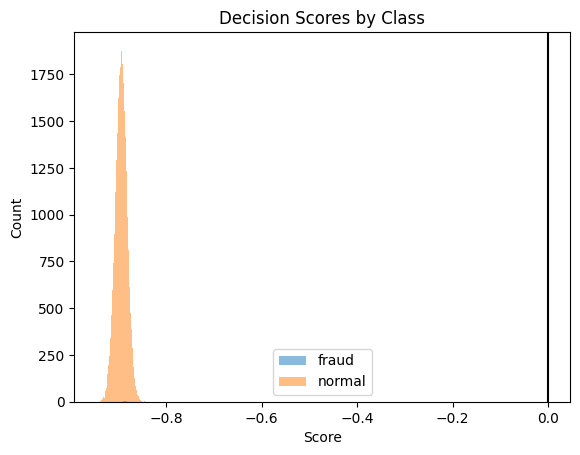

In [16]:
scores = np.dot(X_test if not use_kernel else X_test_kernel, w) + b

plt.hist(scores[Y_test == 1], bins=50, alpha=0.5, label="fraud")
plt.hist(scores[Y_test == -1], bins=50, alpha=0.5, label="normal")

plt.axvline(x=0, color="k", linestyle="-")

plt.legend()
plt.title("Decision Scores by Class")
plt.xlabel("Score")
plt.ylabel("Count")

### Get Evaluation Metrics

In [17]:
(TP, TN, FP, FN), (precision, recall, f1) = evaluate(
    prediction_column_name="PredictedClass"
)

Actual Fraud (Class=1):      49
Actual Non-Fraud (Class=-1): 28432

TP: 0
TN: 28432
FP: 0
FN: 49

PRECISION: nan
RECALL:    0.0
F1-SCORE:  nan

Area Under the Precision-Recall Curve (AUPRC): 0.0017204452090867595


In [18]:
test.head()  # Show what the dataframe looks like with the predicted class column

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,PredictedClass
121884,76355.0,1.177195,0.354835,-0.050112,0.996283,0.114707,-0.533672,0.323340,-0.039656,-0.440988,...,0.269000,-0.093402,0.224293,0.697098,-0.294187,0.000146,-0.002305,1.00,-1,-1
150951,94213.0,1.929328,-0.230009,-0.722492,1.379370,0.327867,0.869605,-0.459958,0.156941,2.348205,...,-1.555905,0.254467,-1.599841,-0.225790,-1.074505,0.018082,-0.057300,34.99,-1,-1
8235,11058.0,1.245603,-0.063529,0.856232,0.336334,-0.916074,-0.863592,-0.496453,-0.153100,1.872207,...,-0.003412,-0.004729,0.377923,0.176246,1.034232,-0.095239,0.003889,15.95,-1,-1
211010,138219.0,-0.939001,1.082314,-0.267542,-1.106319,1.011555,-1.012780,1.054262,-0.143406,0.018528,...,-0.169412,-0.395748,-0.618097,-0.057835,-0.134543,-0.143480,-0.164164,0.01,-1,-1
246098,153033.0,-1.340880,0.364304,1.265265,-0.479915,-0.849015,0.489150,0.766527,0.619257,-0.378495,...,-0.415840,0.275328,-0.553855,0.380016,-0.401064,-0.136261,0.012904,231.12,-1,-1


## Grid Search for Optimal Parameters

In [19]:
# feature_columns = [
#     col for col in test.columns if col not in ["Class", "PredictedClass"]
# ][:30]

# epochs = 5000
# for C in (0.1, 1, 10, 100):
#     for w1 in (10, 50, 100, 500):
#         class_weights: dict[int, float] = {-1: 1.0, 1: w1}
#         for learning_rate in (0.001, 0.005):
#             print(
#                 f"PARAMETERS: C: {C}, w1: {w1}, learning rate: {learning_rate}\n"
#             )

#             w, b, losses = fit(
#                 X_train,
#                 Y_train,
#                 learning_rate=learning_rate,
#                 C=C,
#                 epochs=epochs,
#                 class_weights=class_weights,
#                 decay=1e-3,
#                 log=False,
#             )

#             print(f"WEIGHTS: {w}")
#             print(f"BIAS:    {b}\n")

#             X_test = test[feature_columns].to_numpy()
#             Y_test = test["Class"].to_numpy()

#             test["PredictedClass"] = predict(X_test, w, b)
#             evaluate(prediction_column_name="PredictedClass")

#             print("~" * 50)

## Benchmark Using Existing SciKit Learn Model

### SVC

In [20]:
# from sklearn.svm import SVC

# sklearn_SVC = SVC(
#     kernel="linear",
#     C=C,
#     random_state=42,
#     class_weight=class_weights,
#     max_iter=epochs,
# )
# sklearn_SVC.fit(X_train, Y_train)

# y_pred_sklSVC = sklearn_SVC.predict(X_test)

In [21]:
# test["SKLearnSVCPredictedClass"] = y_pred_sklSVC
# evaluate(prediction_column_name="SKLearnSVCPredictedClass")

### One Class SVM

In [22]:
# from sklearn.svm import OneClassSVM

# sklearn_1CSVM = OneClassSVM(
#     kernel="rbf", nu=0.01, gamma="scale", max_iter=epochs
# )
# sklearn_1CSVM.fit(X_train[Y_train == -1])

# y_scores = sklearn_1CSVM.decision_function(X_test)
# y_pred_skl1CSVM_raw = sklearn_1CSVM.predict(X_test)

# y_pred_skl1CSVM = np.where(y_pred_skl1CSVM_raw == -1, 1, -1)

In [23]:
# test["SKLearn1CSVMPredictedClass"] = y_pred_skl1CSVM
# evaluate(prediction_column_name="SKLearn1CSVMPredictedClass")